In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.optimize
import tqdm
import cvxpy
import itertools
from mpl_toolkits import mplot3d
import matplotlib.image
import imageio

A = np.array([[1, 1, 1],
              [0, 1, 0.5],
              [0, 0, 0.5 * np.sqrt(3)]])

def p_to_xy(p):
  assert p.shape[0] == 3
  _xy = A @ p
  xy = _xy[1:]
  return xy

def xy_to_p(xy):
  assert xy.shape[0] == 2
  _xy = np.concatenate([np.ones_like(xy[:1]), xy])
  return np.linalg.solve(A, _xy)

print(xy_to_p(np.array([0, 0])))
print(xy_to_p(np.array([1, 0])))
print(xy_to_p(np.array([1./2, np.sqrt(3) / 2])))

c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


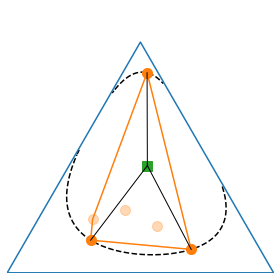

In [9]:
num_states = 3
num_skills = 6

p_s_given_z = np.random.dirichlet(2 * np.ones(num_states), size=num_skills)
p_z = cvxpy.Variable(shape=num_skills)
p_s = p_s_given_z.T * p_z

h_s_given_z = -np.sum(p_s_given_z * np.log(p_s_given_z), axis=1)
h_s = cvxpy.sum(cvxpy.entr(p_s))
mi = h_s - h_s_given_z * p_z

obj = cvxpy.Maximize(mi)
constraints = [cvxpy.sum(p_z) == 1, p_z >= 0]
prob = cvxpy.Problem(obj, constraints)
prob.solve()

xy_vec = p_to_xy(p_s_given_z.T).T
hull = scipy.spatial.ConvexHull(xy_vec)
p_vertices = p_s_given_z[hull.vertices]
xy_vertices = xy_vec[hull.vertices]
xy_vertices_wrapped = np.concatenate([xy_vertices, [xy_vertices[0]]])

p_s_x, p_s_y = p_to_xy(p_s.value)
xy_support = xy_vec[p_z.value > 0.01]

plt.figure(figsize=(4, 4 * np.sqrt(3)))
plt.plot(xy_vec[:, 0], xy_vec[:, 1], 'o', c=c_vec[1], ms=10, alpha=0.3)
plt.plot(xy_vertices_wrapped[:, 0], xy_vertices_wrapped[:, 1], '-', c=c_vec[1])

plt.plot(xy_support[:, 0], xy_support[:, 1], 'o', ms=10, c=c_vec[1])
plt.plot([p_s_x], [p_s_y], 's', c=c_vec[2], ms=10)
for (x, y) in xy_support:
  plt.plot([x, p_s_x], [y, p_s_y], '-', c='k', linewidth=1)

plt.plot([0, 1, 0.5, 0], [0, 0, 0.5 * np.sqrt(3), 0], c=c_vec[0])

kl = np.sum(p_s_given_z[p_z.value > 0.01] * np.log(p_s_given_z[p_z.value > 0.01] / p_s.value[None]), axis=1)
assert kl.max() - kl.min() < 1e-6
d = kl.mean()
size = 100
x = np.linspace(0, 1, size)
y = np.linspace(0, 1, size)
xy = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
p = xy_to_p(xy.T).T
kl = np.sum(p * np.log(p / p_s.value[None]), axis=1)
kl = kl.reshape((size, size))
plt.contour(x, y, kl, levels=[d], colors='k', linestyles='--')

plt.axis('off')
plt.tight_layout()
plt.gca().set_aspect('equal')
plt.savefig('skill.png', dpi=300, bbox_inches='tight')
plt.show()